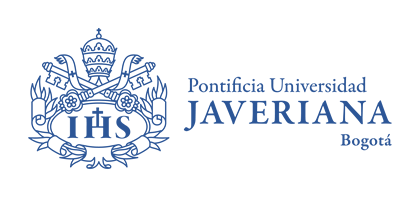

# Aprendizaje profundo - Taller 1
# Reconocimiento de Imagenes del lenguaje de señas


## Cristian Cristancho 
## Nikolas Rodirguez

# Descarga del dataset

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/MAESTRIA IA/2022-1/APRENDIZAJE PROFUNDO/Taller 1/archive.zip" /content

In [ ]:
!unzip -qq archive.zip

# Preprocesamiento de los datos

## Lectura de los datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Lecura de los archivos .csv

In [ ]:
train_df_data = pd.read_csv("/content/sign_mnist_train.csv")
test_df_data = pd.read_csv("/content/sign_mnist_test.csv")

In [ ]:
train_df_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


## Conversion a tensores de numpy

Los datos estan compuestos por imagenes de 28 px x 28 px a blanco y negro, para poder emplear los datos es necesario extraer los datos de los dataframes y ajustarlos para que vuelvan a ser imagenes otra vez.

In [ ]:
Y_train_df = train_df_data["label"]
X_train_df = train_df_data.drop("label", 1)


Y_test_df = test_df_data["label"]
X_test_df = test_df_data.drop("label", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
X_train_np = X_train_df.values
Y_train_np = Y_train_df.values

X_test_np = X_test_df.values
Y_test_np = Y_test_df.values

Los datos de entrada deben quedar de la forma [x, 28,28,1]

In [ ]:
X_train_np = X_train_np.reshape(-1,28,28,1)
print("Datos de entrenamiento:")
print(X_train_np.shape)
print("Datos de test:")
X_test_np = X_test_np.reshape(-1,28,28,1)
print(X_test_np.shape)


Datos de entrenamiento:
(27455, 28, 28, 1)
Datos de test:
(7172, 28, 28, 1)


Los datos de entrada se deben normalizar a valores entre 0 y 1

In [ ]:
X_train_np = X_train_np/255
X_test_np = X_test_np/255

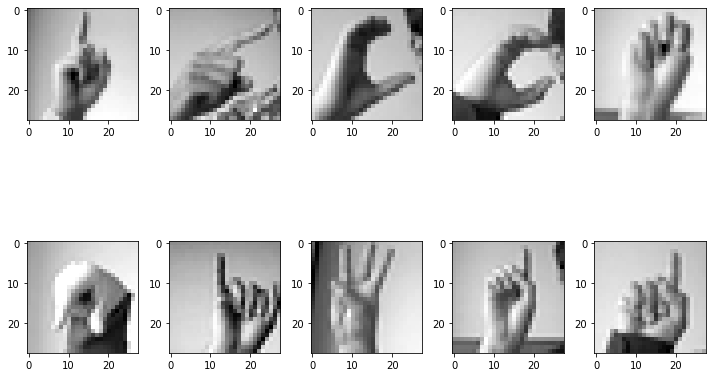

In [ ]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train_np[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

Para los datos de salida se les debe aplicar one-hot encoding para poder ser empleados en la red neuronal

In [ ]:
from keras.utils import np_utils

In [ ]:
Y_train_np = np_utils.to_categorical(Y_train_np)
Y_test_np = np_utils.to_categorical(Y_test_np)

In [ ]:
print("Salidas de entrenamiento:")
print(Y_train_np.shape)
print("Salidas de test:")
print(Y_test_np.shape)

Salidas de entrenamiento:
(27455, 25)
Salidas de test:
(7172, 25)


# Entrenamiento de los modelos

## Componentes necesarios para el entrenamiento y testeo de los modelos

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose,UpSampling2D, Flatten, Reshape, GlobalAveragePooling2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

Metricas a evaluar en los modelos

In [ ]:
METRICS = [ 
      CategoricalAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall')
      ]

Se emplea un callback EarlyStopping para para el entrenamiento de los modelos cuando estos no mejoren mas

In [ ]:
CALLBACKS = EarlyStopping(monitor='val_loss', mode='min', patience=3)

Funciones de apoyo

In [ ]:
def plot_history_model(history_model):

  epocas = np.array(history_model.epoch) + 1

  fig, ax = plt.subplots(2,2)

  train_loss=history_model.history['loss']
  val_loss=history_model.history['val_loss']

  train_accuracy=history_model.history['accuracy']
  val_accuracy=history_model.history['val_accuracy']

  train_precision=history_model.history['precision']
  val_precision=history_model.history['val_precision']

  train_recall=history_model.history['recall']
  val_recall=history_model.history['val_recall']

  fig.set_size_inches(12,12)

  ax[0,0].plot(epocas, train_loss, 'go-', label = 'Train Loss')
  ax[0,0].plot(epocas, val_loss, 'ro-', label = 'Val Loss')
  ax[0,0].set_title('Loss')
  ax[0,0].legend()
  ax[0,0].set_xlabel('Epocas')
  ax[0,0].set_ylabel('Loss')

  ax[0,1].plot(epocas, train_accuracy, 'go-', label = 'Train Accuracy')
  ax[0,1].plot(epocas, val_accuracy, 'ro-', label = 'Val Accuracy')
  ax[0,1].set_title('Accuracy')
  ax[0,1].legend()
  ax[0,1].set_xlabel('Epocas')
  ax[0,1].set_ylabel('Accuracy')
  ax[0,1].set_ylim([0, 1])

  ax[1,0].plot(epocas, train_precision, 'go-', label = 'Train Precision')
  ax[1,0].plot(epocas, val_precision, 'ro-', label = 'Val Precision')
  ax[1,0].set_title('Precision')
  ax[1,0].legend()
  ax[1,0].set_xlabel('Epocas')
  ax[1,0].set_ylabel('Precision')
  ax[1,0].set_ylim([0, 1])

  ax[1,1].plot(epocas, train_recall, 'go-', label = 'Train Recall')
  ax[1,1].plot(epocas, val_recall, 'ro-', label = 'Val Recall')
  ax[1,1].set_title('Recall')
  ax[1,1].legend()
  ax[1,1].set_xlabel('Epocas')
  ax[1,1].set_ylabel('Recall')
  ax[1,1].set_ylim([0, 1])

  fig.suptitle('Resultados de '+ history_model.model.name, size=16)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

def get_metricas(y_true, y_pred):

  classes = ["Clase " + str(i) for i in range(25) if i != 9]
  print(classification_report(y_true,y_pred, target_names=classes))

  cm = confusion_matrix(y_true, y_pred)
  cmp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
  fig, ax = plt.subplots(figsize=(10,10))
  cmp.plot(ax=ax)


def performance_metrics_of_model(model, x, y):

  y_model = model.predict(x)

  y_model = np.argmax(y_model, axis=1)
  y = np.argmax(y, axis=1)

  get_metricas(y, y_model)

## Modelo 1

Este primer modelo solo cuenta con una capa convolucional sencilla y una capa densa.

In [ ]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(8, kernel_size=(3,3), activation='relu')(inputs)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)
outputs=Dense(25,activation='softmax')(x)

model_1 = Model(inputs=inputs, outputs=outputs, name='Modelo_1')

model_1.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=METRICS)

model_1.summary()

Model: "Modelo_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 8)                 43272     
                                                                 
 dense_1 (Dense)             (None, 25)                225       
                                                                 
Total params: 43,577
Trainable params: 43,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 64

history_model_1 = model_1.fit(X_train_np, Y_train_np,
                validation_data=(X_test_np, Y_test_np),
                epochs=epochs,
                callbacks=CALLBACKS)

Epoch 1/64
858/858 [==============================] - 9s 8ms/step - loss: 2.8878 - accuracy: 0.1205 - precision: 0.3837 - recall: 0.0012 - val_loss: 2.7805 - val_accuracy: 0.1371 - val_precision: 1.0000 - val_recall: 0.0028
Epoch 2/64
858/858 [==============================] - 6s 7ms/step - loss: 2.4754 - accuracy: 0.1835 - precision: 0.9111 - recall: 0.0149 - val_loss: 2.6273 - val_accuracy: 0.1510 - val_precision: 0.7904 - val_recall: 0.0184
Epoch 3/64
858/858 [==============================] - 6s 7ms/step - loss: 2.2701 - accuracy: 0.2197 - precision: 0.9315 - recall: 0.0278 - val_loss: 2.5227 - val_accuracy: 0.1662 - val_precision: 0.9789 - val_recall: 0.0194
Epoch 4/64
858/858 [==============================] - 6s 7ms/step - loss: 2.1230 - accuracy: 0.2550 - precision: 0.9291 - recall: 0.0329 - val_loss: 2.4764 - val_accuracy: 0.1942 - val_precision: 0.9432 - val_recall: 0.0231
Epoch 5/64
858/858 [==============================] - 6s 7ms/step - loss: 2.0016 - accuracy: 0.2927 - pr

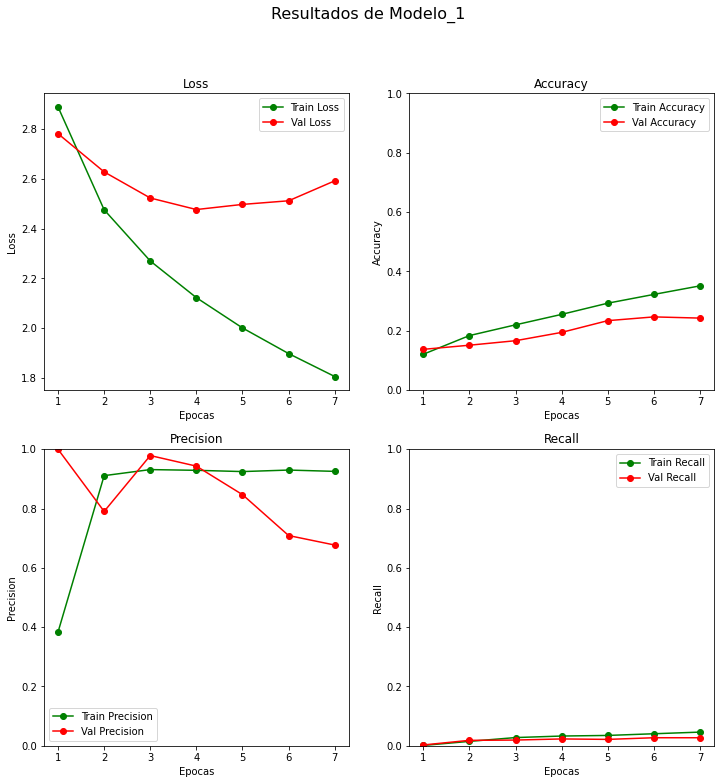

In [ ]:
plot_history_model(history_model_1)

              precision    recall  f1-score   support

     Clase 0       0.21      0.92      0.34       331
     Clase 1       0.49      0.57      0.53       432
     Clase 2       0.78      0.53      0.63       310
     Clase 3       0.03      0.01      0.01       245
     Clase 4       0.00      0.00      0.00       498
     Clase 5       0.15      0.11      0.13       247
     Clase 6       0.40      0.20      0.27       348
     Clase 7       0.58      0.44      0.50       436
     Clase 8       0.25      0.00      0.01       288
    Clase 10       0.00      0.00      0.00       331
    Clase 11       0.25      0.67      0.36       209
    Clase 12       0.00      0.00      0.00       394
    Clase 13       0.01      0.01      0.01       291
    Clase 14       0.37      0.50      0.43       246
    Clase 15       0.00      0.00      0.00       347
    Clase 16       0.10      0.60      0.17       164
    Clase 17       0.10      0.38      0.15       144
    Clase 18       0.11    

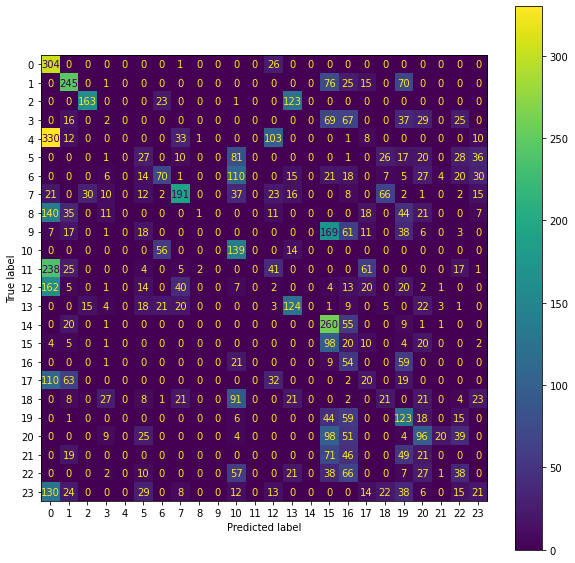

In [ ]:
performance_metrics_of_model(model_1, X_test_np, Y_test_np)

Resultados: 
El modelo presento un rendimiento muy bajo, aunque el objetivo de este modelo es servir de punto de inicio.

## Modelo 2

En esta segunda iteracion se aumenta al doble de los filtros presentes en la capa convolucional

In [ ]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(16, kernel_size=(3,3), activation='relu')(inputs)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)
outputs=Dense(25,activation='softmax')(x)

model_2 = Model(inputs=inputs, outputs=outputs, name='Modelo_2')

model_2.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=METRICS)

model_2.summary()

Model: "Modelo_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 86536     
                                                                 
 dense_5 (Dense)             (None, 25)                225       
                                                                 
Total params: 86,921
Trainable params: 86,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 64

history_model_2 = model_2.fit(X_train_np, Y_train_np,
                validation_data=(X_test_np, Y_test_np),
                epochs=epochs,
                callbacks=CALLBACKS)

Epoch 1/64
858/858 [==============================] - 14s 15ms/step - loss: 3.2055 - accuracy: 0.1768 - precision: 0.9194 - recall: 0.0293 - val_loss: 3.2115 - val_accuracy: 0.0201 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/64
858/858 [==============================] - 10s 12ms/step - loss: 3.1908 - accuracy: 0.0471 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.2092 - val_accuracy: 0.0201 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/64
858/858 [==============================] - 7s 8ms/step - loss: 3.1847 - accuracy: 0.0468 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.2071 - val_accuracy: 0.0201 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/64
858/858 [==============================] - 6s 7ms/step - loss: 3.1814 - accuracy: 0.0451 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.2053 - val_accuracy: 0.0201 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/64
858/858 [========================

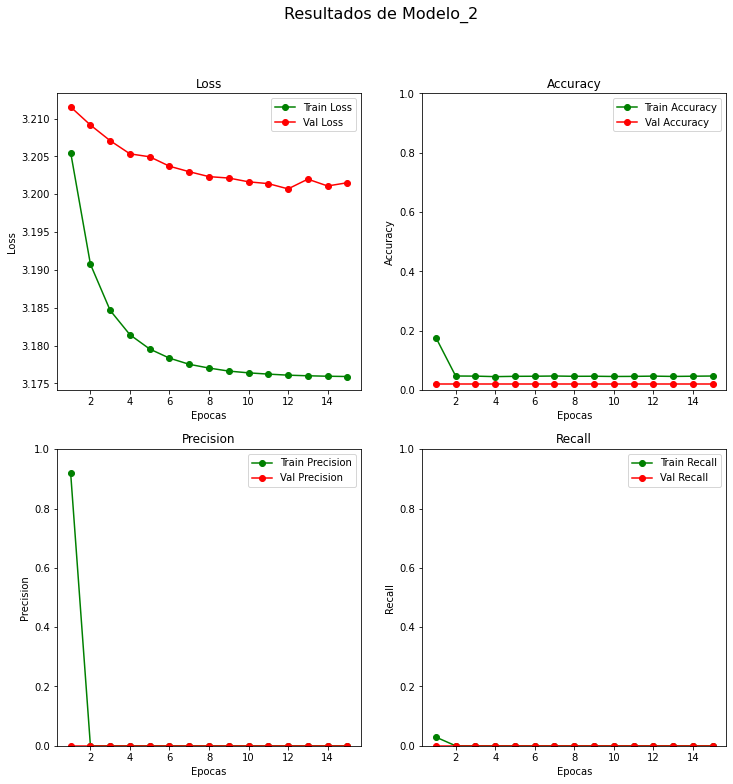

In [ ]:
plot_history_model(history_model_2)

              precision    recall  f1-score   support

     Clase 0       0.00      0.00      0.00       331
     Clase 1       0.00      0.00      0.00       432
     Clase 2       0.00      0.00      0.00       310
     Clase 3       0.00      0.00      0.00       245
     Clase 4       0.00      0.00      0.00       498
     Clase 5       0.00      0.00      0.00       247
     Clase 6       0.00      0.00      0.00       348
     Clase 7       0.00      0.00      0.00       436
     Clase 8       0.00      0.00      0.00       288
    Clase 10       0.00      0.00      0.00       331
    Clase 11       0.00      0.00      0.00       209
    Clase 12       0.00      0.00      0.00       394
    Clase 13       0.00      0.00      0.00       291
    Clase 14       0.00      0.00      0.00       246
    Clase 15       0.00      0.00      0.00       347
    Clase 16       0.00      0.00      0.00       164
    Clase 17       0.02      1.00      0.04       144
    Clase 18       0.00    

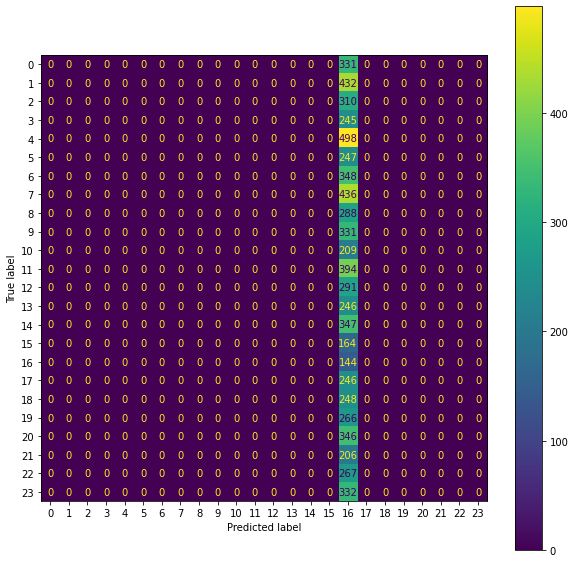

In [ ]:
performance_metrics_of_model(model_2, X_test_np, Y_test_np)

Resultados: A pesar de haber aumentado la cantidad de filtro en la capa convolucional el rendimiento del modelo no mejoro en lo mas minimo, es mas empeoro.

## Modelo 3

En esta version del modelo se procedio a incluir mas capas convloluionales, ademnas de ir aumentando en potencias de dos la cantidad de filtros en cada capa sucesiva, ademas de proveer mas neuronas en la capa fully connected.

In [ ]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(16, kernel_size=(3,3), activation='relu')(inputs)
x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
outputs=Dense(25,activation='softmax')(x)

model_3 = Model(inputs=inputs, outputs=outputs, name='Modelo_3')

model_3.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=METRICS)

model_3.summary()

Model: "Modelo_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 dense_10 (Dense)            (None, 16)                294928    
                                                                 
 dense_11 (Dense)            (None, 25)                425       
                                                                 
Total params: 300,153
Trainable params: 300,153
Non-traina

In [ ]:
epochs = 64

history_model_3 = model_3.fit(X_train_np, Y_train_np,
                validation_data=(X_test_np, Y_test_np),
                epochs=epochs,
                callbacks=CALLBACKS)

Epoch 1/64
858/858 [==============================] - 10s 10ms/step - loss: 2.4314 - accuracy: 0.1873 - precision: 0.8327 - recall: 0.0322 - val_loss: 2.0076 - val_accuracy: 0.3557 - val_precision: 0.7254 - val_recall: 0.1194
Epoch 2/64
858/858 [==============================] - 8s 10ms/step - loss: 1.0590 - accuracy: 0.6569 - precision: 0.8374 - recall: 0.4009 - val_loss: 2.0843 - val_accuracy: 0.5003 - val_precision: 0.5770 - val_recall: 0.3897
Epoch 3/64
858/858 [==============================] - 8s 10ms/step - loss: 0.4942 - accuracy: 0.8566 - precision: 0.9069 - recall: 0.7695 - val_loss: 2.5826 - val_accuracy: 0.5322 - val_precision: 0.5796 - val_recall: 0.4886
Epoch 4/64
858/858 [==============================] - 8s 10ms/step - loss: 0.3023 - accuracy: 0.9186 - precision: 0.9443 - recall: 0.8918 - val_loss: 3.1546 - val_accuracy: 0.5376 - val_precision: 0.5615 - val_recall: 0.5172


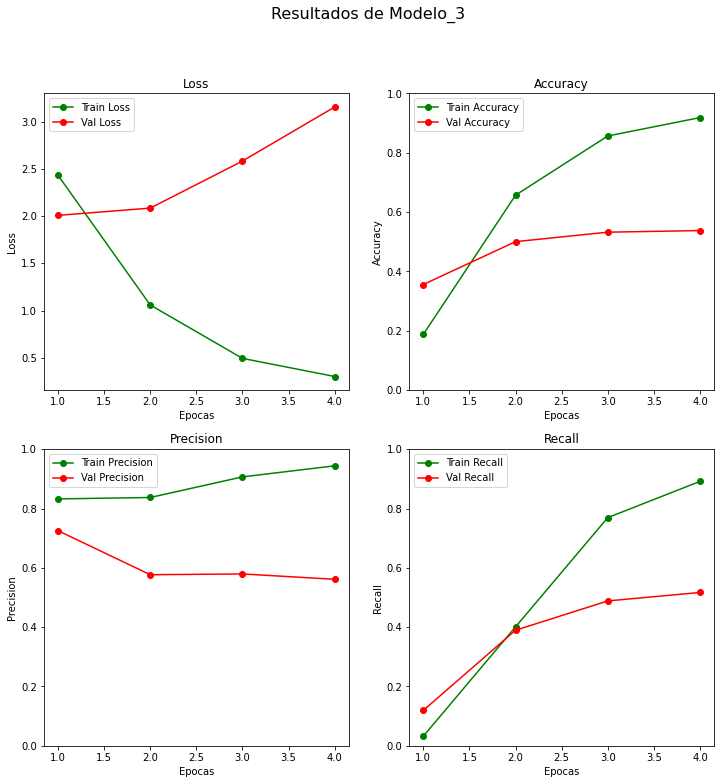

In [ ]:
plot_history_model(history_model_3)

              precision    recall  f1-score   support

     Clase 0       0.67      0.83      0.74       331
     Clase 1       0.78      0.63      0.70       432
     Clase 2       0.86      0.80      0.83       310
     Clase 3       0.61      0.78      0.69       245
     Clase 4       0.75      0.67      0.71       498
     Clase 5       0.58      0.69      0.63       247
     Clase 6       0.48      0.30      0.37       348
     Clase 7       0.79      0.72      0.76       436
     Clase 8       0.41      0.49      0.45       288
    Clase 10       0.56      0.41      0.47       331
    Clase 11       0.59      1.00      0.74       209
    Clase 12       0.36      0.37      0.37       394
    Clase 13       0.55      0.20      0.30       291
    Clase 14       0.49      0.45      0.47       246
    Clase 15       0.37      0.37      0.37       347
    Clase 16       0.29      0.37      0.32       164
    Clase 17       0.20      0.28      0.24       144
    Clase 18       0.38    

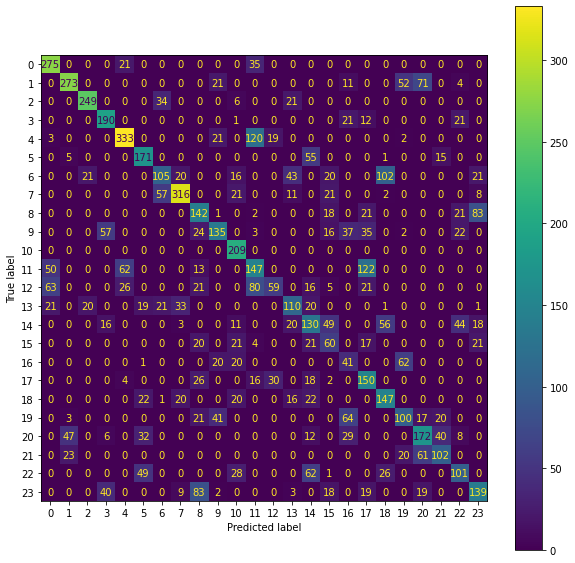

In [ ]:
performance_metrics_of_model(model_3, X_test_np, Y_test_np)

Resultados: El modelo 3 presento un rendimiento muy superior a sus antecesores, pero el numero de parametros en el modelo se incremento debido a la mayor cantidad de capas convolucionales.

## Modelo 4

Para esta iteracion del modelo se incluyo otra capa convolucional mas, pero ademas se incluyeron capas de max pooling por cada capa convolucional.

In [ ]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(16, kernel_size=(3,3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
outputs=Dense(25,activation='softmax')(x)

model_4 = Model(inputs=inputs, outputs=outputs, name='Modelo_4')

model_4.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=METRICS)

model_4.summary()

Model: "Modelo_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 3, 3, 64)          184

In [ ]:
epochs = 64

history_model_4 = model_4.fit(X_train_np, Y_train_np,
                validation_data=(X_test_np, Y_test_np),
                epochs=epochs,
                callbacks=CALLBACKS)

Epoch 1/64
858/858 [==============================] - 9s 9ms/step - loss: 1.9713 - accuracy: 0.4229 - precision: 0.6922 - recall: 0.2597 - val_loss: 1.2626 - val_accuracy: 0.5891 - val_precision: 0.7870 - val_recall: 0.4235
Epoch 2/64
858/858 [==============================] - 8s 9ms/step - loss: 0.7160 - accuracy: 0.7617 - precision: 0.8799 - recall: 0.6319 - val_loss: 0.8504 - val_accuracy: 0.7263 - val_precision: 0.7975 - val_recall: 0.6368
Epoch 3/64
858/858 [==============================] - 8s 9ms/step - loss: 0.3504 - accuracy: 0.8938 - precision: 0.9336 - recall: 0.8389 - val_loss: 0.7496 - val_accuracy: 0.7575 - val_precision: 0.7912 - val_recall: 0.7164
Epoch 4/64
858/858 [==============================] - 8s 9ms/step - loss: 0.1648 - accuracy: 0.9568 - precision: 0.9695 - recall: 0.9399 - val_loss: 0.6647 - val_accuracy: 0.8112 - val_precision: 0.8380 - val_recall: 0.7978
Epoch 5/64
858/858 [==============================] - 8s 9ms/step - loss: 0.0836 - accuracy: 0.9802 - pr

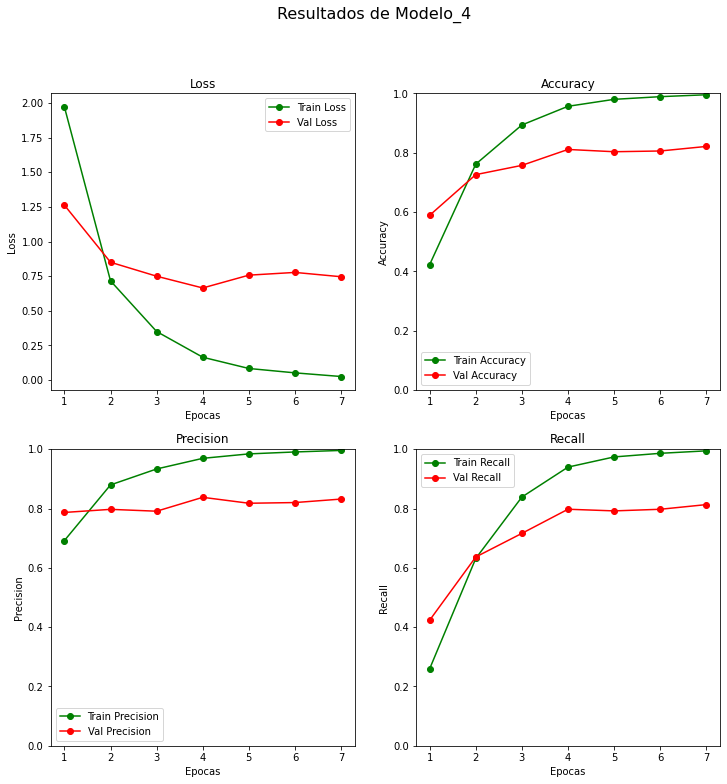

In [ ]:
plot_history_model(history_model_4)

              precision    recall  f1-score   support

     Clase 0       0.83      0.96      0.89       331
     Clase 1       1.00      0.94      0.97       432
     Clase 2       0.92      0.83      0.87       310
     Clase 3       0.71      0.78      0.74       245
     Clase 4       0.92      0.91      0.92       498
     Clase 5       0.97      0.91      0.94       247
     Clase 6       0.86      0.73      0.79       348
     Clase 7       0.84      0.93      0.88       436
     Clase 8       0.80      0.77      0.79       288
    Clase 10       0.81      0.73      0.77       331
    Clase 11       0.95      0.86      0.90       209
    Clase 12       0.73      0.73      0.73       394
    Clase 13       0.72      0.72      0.72       291
    Clase 14       0.85      0.76      0.80       246
    Clase 15       0.91      0.95      0.93       347
    Clase 16       0.89      0.87      0.88       164
    Clase 17       0.65      0.71      0.68       144
    Clase 18       0.64    

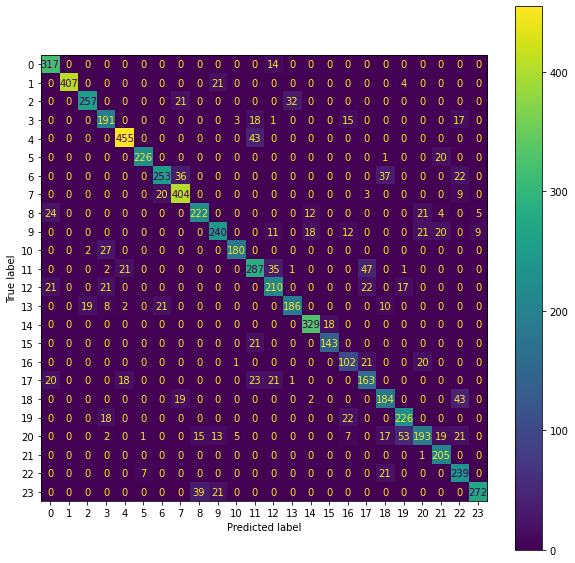

In [ ]:
performance_metrics_of_model(model_4, X_test_np, Y_test_np)

Resultados: El incluir las capas de max pooling al modelo incrementaron de manera vertiginosa el rendimiento general del modelo, ademas de que reducieron drasticamente el numero de parametros del mismo, siendo esta uno de los cambios que mas han aportado al rendimiento del modelo, aunque se evidencia un poco de overfitting.

## Modelo 5

Para solventar el problema del overfitting se procede a aplicar dropout a las capas del modelo.

In [ ]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(16, kernel_size=(3,3), activation='relu')(inputs)
x = Dropout(0.3)(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
outputs=Dense(25,activation='softmax')(x)

model_5 = Model(inputs=inputs, outputs=outputs, name='Modelo_5')

model_5.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=METRICS)

model_5.summary()

Model: "Modelo_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 dropout (Dropout)           (None, 26, 26, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 32)        0         
                                                          

In [ ]:
epochs = 64

history_model_5 = model_5.fit(X_train_np, Y_train_np,
                validation_data=(X_test_np, Y_test_np),
                epochs=epochs,
                callbacks=CALLBACKS)

Epoch 1/64
858/858 [==============================] - 10s 10ms/step - loss: 2.7409 - accuracy: 0.2894 - precision: 0.8084 - recall: 0.1891 - val_loss: 2.2863 - val_accuracy: 0.4112 - val_precision: 1.0000 - val_recall: 0.0167
Epoch 2/64
858/858 [==============================] - 8s 10ms/step - loss: 1.8412 - accuracy: 0.3759 - precision: 0.7299 - recall: 0.1499 - val_loss: 1.6529 - val_accuracy: 0.5655 - val_precision: 0.9479 - val_recall: 0.0609
Epoch 3/64
858/858 [==============================] - 8s 9ms/step - loss: 1.4222 - accuracy: 0.4935 - precision: 0.7564 - recall: 0.2766 - val_loss: 1.2657 - val_accuracy: 0.7274 - val_precision: 0.9533 - val_recall: 0.1707
Epoch 4/64
858/858 [==============================] - 8s 9ms/step - loss: 1.1954 - accuracy: 0.5651 - precision: 0.7744 - recall: 0.3749 - val_loss: 1.0739 - val_accuracy: 0.7511 - val_precision: 0.9713 - val_recall: 0.2787
Epoch 5/64
858/858 [==============================] - 8s 9ms/step - loss: 0.9949 - accuracy: 0.6345 -

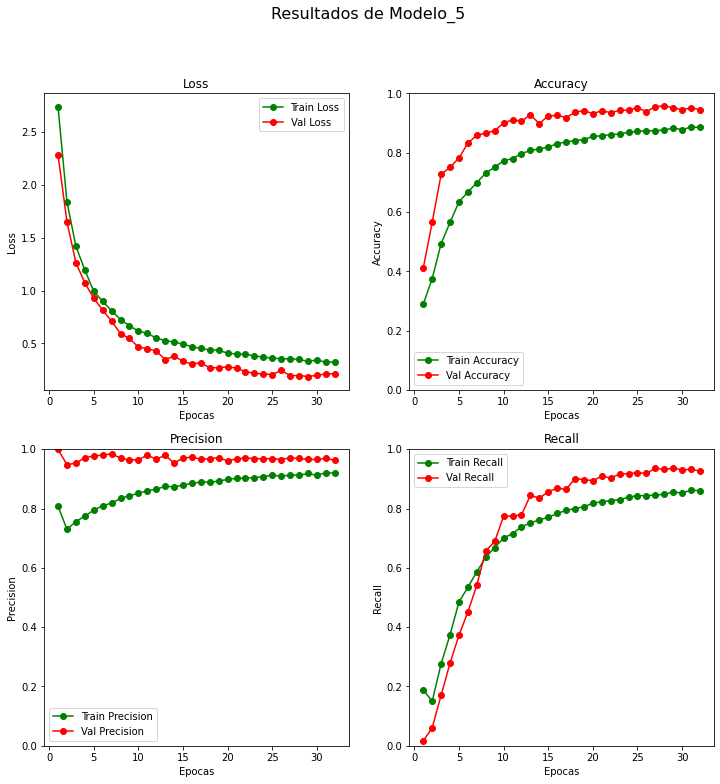

In [ ]:
plot_history_model(history_model_5)

              precision    recall  f1-score   support

     Clase 0       1.00      0.99      1.00       331
     Clase 1       1.00      0.98      0.99       432
     Clase 2       0.93      0.94      0.94       310
     Clase 3       1.00      0.93      0.97       245
     Clase 4       1.00      0.95      0.98       498
     Clase 5       1.00      1.00      1.00       247
     Clase 6       0.88      0.78      0.82       348
     Clase 7       0.89      1.00      0.94       436
     Clase 8       0.89      0.97      0.93       288
    Clase 10       0.93      0.94      0.94       331
    Clase 11       0.92      1.00      0.96       209
    Clase 12       1.00      0.99      0.99       394
    Clase 13       0.99      0.95      0.97       291
    Clase 14       1.00      0.83      0.91       246
    Clase 15       1.00      1.00      1.00       347
    Clase 16       1.00      0.99      1.00       164
    Clase 17       0.98      0.85      0.91       144
    Clase 18       0.84    

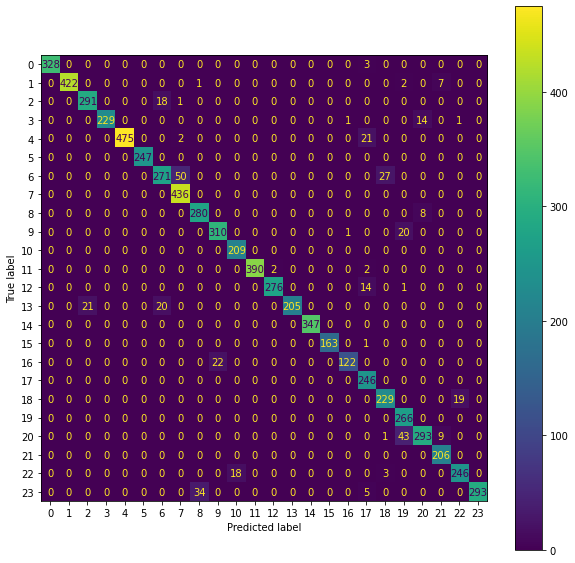

In [ ]:
performance_metrics_of_model(model_5, X_test_np, Y_test_np)

Resultados: Al agregar el dropout al modelo se soluciono casi totalmente el problema del overfitting ademas de que el rendimiento del modelo en general mejoro. 